In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os
import sys

project_path = os.path.abspath(os.path.join('..', '..'))
if project_path not in sys.path:
    sys.path.append(project_path)

from dataclasses import dataclass

import torch
import numpy as np
from tqdm import tqdm

from attention_sgd.models.attention.attention import AttentionOperation
from attention_sgd.utils.observer_utils import MultiObserver
from attention_sgd.utils.torch_utils import default_device
from attention_sgd.batched_task import BatchedTask
from attention_sgd.learning_loop import LearningLoop
from attention_sgd.search_agent import SearchAgent
from attention_sgd.search_task import ToZeroTorchTask

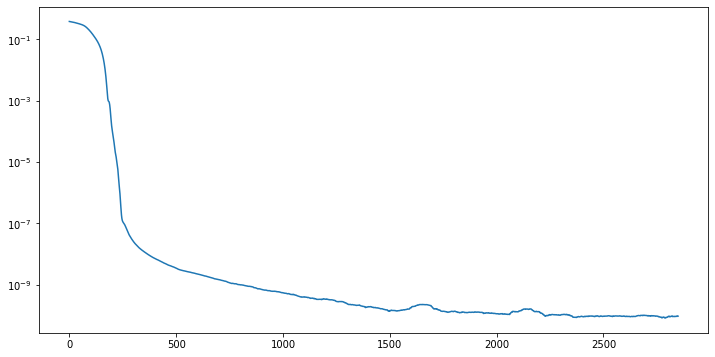

100%|██████████| 3000/3000 [00:51<00:00, 58.61it/s]


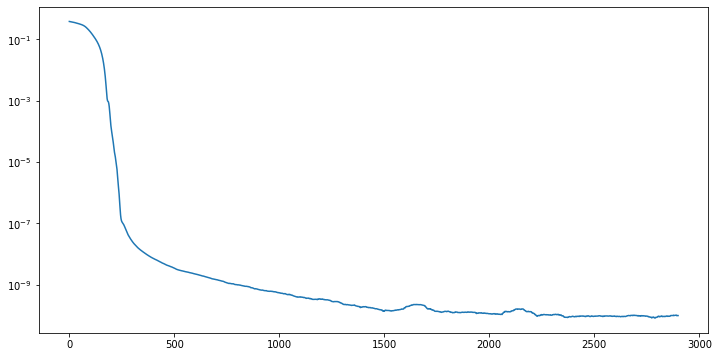

In [19]:
@dataclass
class Params:
    batch_size: int = 32
    hidden_state_size: int = 16
    id_size: int = 31  # must be value_size - 1
    key_size: int = 2
    value_size: int = 32

    epochs: int = 3000
    rollout_size: int = 2

    # ignore_error_start_steps: int = 5
    # training_reset_targets_period: int = -1
    learning_rate: float = 1e-3

    task_size: int = 5
    n_experts: int = 5

    save_period: int = 100
    image_save_period: int = 100
    attention_beta: float = 8
    attention_operation: str = 'euclidean_distance'


p = Params()

agent = SearchAgent(hidden_state_size=p.hidden_state_size, key_size=p.key_size, id_size=p.id_size,
                    value_size=p.value_size, input_size=1, n_inputs=p.task_size,
                    attention_beta=p.attention_beta,
                    attention_operation=AttentionOperation.from_string(p.attention_operation),
                    learning_rate=p.learning_rate).to(default_device())

task = BatchedTask(p.batch_size, lambda: ToZeroTorchTask(p.task_size))
inner_loop = LearningLoop()
loss = []
for epoch in tqdm(range(1, p.epochs + 1)):
    # with torch.autograd.detect_anomaly():
    should_save_images = epoch % p.image_save_period == 0
    observer = MultiObserver() if should_save_images else None

    agent.optim.zero_grad()
    agent.init_rollout(p.batch_size, p.n_experts)
    err = inner_loop.train_fixed_steps(agent, task, p.rollout_size, observer)
    err = torch.mean(err)
    err.backward()
    agent.optim.step()

    loss.append(err.cpu().detach().item())

    if observer is not None:
        tensors = [o.tensors_as_dict() for o in observer.observers]

    # log targets
    if epoch % 50 == 0:
        plt.gcf().set_size_inches((12, 6))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        
        # Average loss
        cs = np.cumsum(loss)
        cs = (cs[100:] - cs[:-100]) / 100.0
        plt.clf()
        plt.plot(cs)
        plt.yscale('log')